# Tensorflow Basic concepts

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [2]:
import scipy.io
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import confusion_matrix
from IPython.display import Image
from addutils import css_notebook
css_notebook()

In [3]:
import bokeh.plotting as bk
bk.output_notebook()

Loading BokehJS ...

# 1 Introduction

**TODO:** Deep learning, cos'è tensorflow (breve storia) e perché è utile, utilizzo della GPU.

The main argument we treat in this notebook is TensorFlow, a library for machine learning and deep learning recently open sourced by google. For more information please visit [TensorFlow](http://www.tensorflow.org).

TensorFlow, is conceptually similar to theano; the computation is formally a graph, with nodes representing operations while edges representing tensors (multidimensional data) communicated between operations. According to TensorFlow web site, the flow of tensors through the graph is where TensorFlow gets its name. It is not intended to be only a neural network library but to perform any computation that can be expressed as a graph. TensorFlow automatic differentiation is especially suited for gradient based machine learning algorithms. The library is written in C++ and it has nice Python bindings. Moreover it can run both on CPU and GPU.

## 1.1 Installation

This notebook requires few additional packages. Please be sure to install them properly before running the notebook. 

We suggest to follows the steps outlined in: [https://www.tensorflow.org/install/](https://www.tensorflow.org/install/)

In particular if you want to use this notebook on your laptop (*without* GPU support) we suggest to create an anaconda environment and follow pip installation process:

- `conda create --name tf python=3.6.2`
- install additional packages (addutils, pandas, scikit-learn, jupyter)
- `source activate tf`
- `pip install --upgrade tensorflow`

These simple steps allow you to run the notebooks, although with poorer performance.

**TODO:** Come installare CUDA e cudnn cosa sono e installare la versione con supporto per la GPU. Compilazione.

## 2 Tensorflow Basics

First import tensorflow and show current version. At the moment of writing we are using tensorflow version 1.3.

In [4]:
import tensorflow as tf
tf.__version__

'1.3.0'

TensorFlow represent computations as **graphs**. Nodes in the graph are called **ops** (operations). An op takes zero or more **Tensors** and produces zero or more Tensors as output. A Tensor is a multidimensional array with a specified type. The graph is a description of a computation, in order to actually execute the computation a graph must be launched in a **session**. A session exectue a specific graph on one of the available **devices** (that can be either CPUs or GPUs).

In following paragraphs we will clarify these concepts.

### 2.1 Computation Graphs

TensorFlow programs are usually structured into a construction phase, that assembles a graph, and an execution phase that uses a session to execute ops in the graph.

For example, it is possible to represent and train a neural network in the construction phase, and then repeatedly execute a set of training ops in the graph in the execution phase.

It is possibile to build a graph by starting with nodes that do not need any input, such as constant nodes. Then it is possible to use the output of the constant node as input to other operations. TensorFlow uses a default graph to which operations are added, the default graph is created empty as soon as tensorflow is imported. It is sufficient for most operations but it is also possible to manage multiple graphs with the `Graph` class.

In [5]:
x = tf.constant(4.)
y = tf.constant(3.)
product = tf.multiply(x, y)

The code creates three nodes: two constant and an operation (multiplication) that takes two inputs (the two constants) and produces an output (product). To actually procude an output is is necessary to run the graph in a session. 

What is the difference between this expression and a corresponding plain python code that multiply two constants? Try to print the result:

In [6]:
print(product)

Tensor("Mul:0", shape=(), dtype=float32)


The key idea is that `product` does not compute the product of x and y but rather add the product operator to a graph of computation that will be executed later. 

**Computation Graphs** allow us to implement ML algorithms by creating and executing operations that interacts with each others. The interaction between operations constitutes the graph. 

What is a graph in the end? It is a set of *nodes* (or vertices) interconnected by (directed) *edges*. Edges allow data to **flow** from one node to another. Each node represent an operation, that produces an ouput that is passed on in the graph. Operations can be of any kind, from math to logging operation (we will se more on this when we will use TensorBoard).

The graph connectivity defines a set of node dependencies, TensorFlow is able to optimize the computation based on this dependencies. Being able to identify connectivities allows to distribute computation and avoid performing redundant computations on irrelevant portion of the graph.

We can add other operations to the graph. For example we can do a sum after the product.

In [7]:
z = tf.constant(8.)
addition = tf.add(product, z)

The next image represent the default graph for the operations defined before

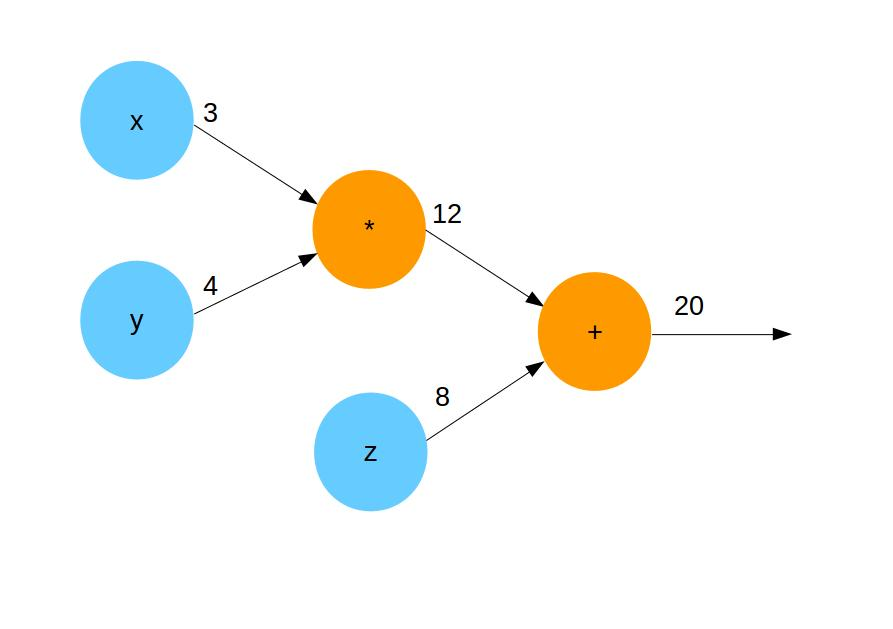

In [8]:
Image('images/computation_graph_example.jpg', width=600, height=600)

Remember that the name of the variables (x, y and product) should be regarded as the output of the operations and not the opration themselves. Note that for some arithmetic and logical operation it is possible to use operator overloading instead of using `tf.<operator>`. For example the multiplication could be written `product = x * y`.

It is possible to create additional graphs and control how operations and variables get associated with them. `tf.Graph()` creates a new graph. To check which graph is currently se as default we use:

In [9]:
g_default = tf.get_default_graph()
print(g_default)

Now we create a new graph g.

In [10]:
g = tf.Graph()
print(g)

As you can see they are diffrent objects. Also, given a node, we can see to which graph is associated:

In [11]:
print(x.graph is g)
print(x.graph is g_default)

False
True


Using `with` statement we can control which graph is set as default and add new nodes to it. For example we can do:

In [12]:
print(g is tf.get_default_graph())

with g.as_default():
    print(g is tf.get_default_graph())
    
print(g_default is tf.get_default_graph())

False
True
True


### 2.2 Sessions

Once the computation graph is defined we can use it in a **Session** to actually obtain the result. Session objects are part of TensorFlow API that are responsible for the communication between data and objects and compuational resources. The computation is performed with the method `run()` of the session object. Without arguments `Session` uses the default graph. 

In [13]:
with tf.Session() as sess:
    result = sess.run([addition])
    print(result)

[20.0]


It is necessary to close a session after last operation, to release computational resources; closing a session is done with the method `close()`. It is possible to use `with ... as  ...` statement, that takes care of releasing resources when computation is finished.

Tensorflow translates the graph into executable operations and it distributes the computation automatically on available resources. It uses the available **GPU** for as many operations as possible.

It is possible to use a **specific device** for a session with `with tf.device("/gpu:1"):` statement. For example previous command execute the graph on the second GPU of the machine. Try to change the string and execute the code on CPU (or another GPU of your machine)

In [14]:
with tf.Session() as sess:
    with tf.device("/cpu:0"):
        result = sess.run([addition])
        print(result)

[20.0]


In the these example we requested a particular node of the graph, by passing it to the method `run()`. This is called **fetch** and the arguments of the function are the fetches. It is possible to fetch more than one variable by passing them simultaneously to the run() command (`session.run([var1, var2])`). The result is a list of values fetched. As we said earlier, TensorFlow computes only the necessary portion of the graph if we ask to compute only the product, only the output of node product is computed (involving only the nodes to which it depends)

In [15]:
with tf.Session() as sess:
    result = sess.run([product, addition])
    print(result)

[12.0, 20.0]


In an interactive environment like IPython or Jupyter it could be useful to interleave graph construction and run operations, you can use `InteractiveSession`. The only difference with a regular `Session` is that an `InteractiveSession` installs itself as the default session on construction. The methods `Tensor.eval()` and `Operation.run()` will use that session to run ops.

In [16]:
sess = tf.InteractiveSession()
c = tf.linspace(0.0, 1.0, 5)
print(c.eval())

[ 0.    0.25  0.5   0.75  1.  ]


In [17]:
g = tf.get_default_graph()
operations = [op for op in g.get_operations()]

In [28]:
[op.name for op in operations]

['Const',
 'Const_1',
 'Mul',
 'Const_2',
 'Add',
 'LinSpace/start',
 'LinSpace/stop',
 'LinSpace/num',
 'LinSpace']

Running an operation makes tensorflow running all the operations required for the input of this operation, but doesn't return anything. It is also possible to get tensors and operations by name from a graph.

Now we close interactive session.

In [ ]:
sess.close()

### 2.3 Tensors

TensorFlow uses **Tensors** to represents all data. Only tensors are passed between ops in the graph. Tensors are an n-dimensional arrays, and, in TensorFlow, are described with rank, shape and type. The rank its the number of dimensions (different from matrix rank), the shape is the number of elements for each dimension and the type is the data type assigned to the tensor.

When we create an operation for example with tf.add(), the operation is a *node* added to the graph but the handle we get is the tensor that results from the operation. This handle is the *edge* of the graph and it passes (**flow**) the yet-to-be-computed result of the operation to other nodes.

Tensors objects have attributes and operations. For example the tensor `x` is a tensor with no shape (actually shape 1x1) that is a scalar, and it's dtype is a float32:

In [ ]:
print(x)

Tensors dtype can be specified at creation time or can be modified later using `tf.cast` operation. Tensor can be viewed as n-dimensional arrays. As we have already seen a $1 \times 1$ tensor is a scalar, a $1 \times n$ tensor is a vector, a $n \times n$ tensor is a matrix, a $n \times n \times n$ tensor is a three dimensional array, and so on (it can be generalized to any dimension). As with dtypes, TensorFlow can infer automatically the dimension of a tensor object given the shape of the data. For example if we want to create a matrix with `tf.constant` and see what shape we get, we can use the following code:

In [ ]:
w = tf.constant([[1,2,3], 
                 [4,5,6]])
print(w.get_shape())

Other types of operations that generates number without user input are random number generation operators, linspace (as seen before), array of constant (one or zero values) and many others. They resemble the operations and API used by numpy. 

An important operation that we will use often is matrix multiplication. It is needed to perform operations like $Ax=b$, where $A$ is a matrix and $x$ is a vector.

In [ ]:
A = tf.constant([[1,2,3],
                 [4,5,6]])
print(A.get_shape())
x = tf.constant([[1],[0],[1]])
print(x.get_shape())

In [ ]:
sess = tf.InteractiveSession()
b = tf.matmul(A,x)
print(b.eval())
sess.close()

Tensors have a name as well, it can be assigned at creation time or TensorFlow assign it for  you (as happened before). It can be displayed with method `name`. The name of the objec is simply the name of the operation followed by a colon and the index of that tensor in the output of the operation that produced it. If two or more operations exists, tensorflow add an underscore to its names followed by a progressive number to avoid tensors with the same name.

In [ ]:
b.name

Sometimes can be useful, especially in complicated graphs, to group together related tensors, that belong to a certain portion of the graph for example. **Name scopes** are used for this purpose. Here's an example.

In [ ]:
with tf.Graph().as_default():
    a1 = tf.constant(4,dtype=tf.float64, name='variable_a1')
    with tf.name_scope("group"):
        group_a1 = tf.constant(4,dtype=tf.int32,name='variable_a1')
        group_a2 = tf.constant(4,dtype=tf.int32,name='variable_a2')

print(a1.name)
print(group_a1.name)
print(group_a2.name)

#### 2.3.1 Variables and Placeholders

**Variables** are used to maintain state accross executions of the graph. In this example `state` is initialized to zero and updated each time `update` is run. When using variables, they must be initialized after launching the graph, that is after creating a session. In order to initialize the variables it is necessary to add an init operation that must be run *before* all other operations.

In [ ]:
state = tf.Variable(0, name="counter")

one = tf.constant(1)
new_value = tf.add(state, one)
update = tf.assign(state, new_value)

init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    print('state: ' + str(sess.run(state)))
    for _ in range(5):
        sess.run(update)
        print('state: ' + str(sess.run(state)))

Here `assign` is part of the computational graph as `add` and other operators. Variables are typically used to represent parameters of a model, for example in neural network they are used to store the weights matrix, that it is updated at every execution of the graph. Parameters are updated by the operations in the graph as the result of the optimization process. 

Variables can be initialized to random values, using a distribution (in the previous example it was initialized to zero). For example we can use a random normal distribution with given mean and standard deviation, as well as specify resulting shape.

In [ ]:
init_val = tf.random_normal((1,5), 0, 1)
var = tf.Variable(init_val, name='var')

print('tensor object: {}'.format(var))

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    initialized_values = sess.run(var)
    
print('tensor values after init: {}'.format(initialized_values))

Note that if we run the code several times the output changes, but also the object changes (look at the name of the object!). A new variable is created every time `tf.Variable` method is called. We will see how to use this feature later on.

So far we have covered how to store values in constant and use variable to update their values (these operations are calle *source* operations). TensorFlow provides also a method to pass a value to the variables with a **feed** mechanism. A feed replace the value of a tensor with the value that you provide. Tensorflow provides a special structure called **placeholder** for feeding input values. Placeholders have an optional shape parameter, that can be set to `None` meaning that the shape can be of any size (we will see that it is common for mini-batches later on). To feed the values we construct a dictionary whose keys correspond to placeholder variables and values can be list or numpy arrays to feed to each variable.

In [ ]:
input1 = tf.placeholder(tf.float32)
input2 = tf.placeholder(tf.float32)
output = input1 * input2

with tf.Session() as sess:
    print(sess.run([output], feed_dict={input1:[7.], input2:[2.]}))

A variable declaered as placeholder expects a feed and generate an error if it is not supplied

## 3 Building Models

Now tensorflow is especially useful to train Machine Learning models. We will briefly sketch the workflow of building simple models. We will switch to more complex models (Neural Networks) later on. 

### 3.1 Linear Regression example

The most simple model to build is based on a target variable $y$ that we are trying to predict given input data $x$. We have a set of $x$ and $y$ values that we use to train the model. Suppose that $y$ is a vector with continuous values, we have a regression model that can be described with a simple equation: $f(x) = w^Tx + b$ and $y = f(x) + \epsilon$, where 
$f(x)$ is a linear combination of our training data $x$, with a set of weights $w$ and an intercept $b$. The target $y$ is equal to $f(x)$ with added gaussian noise. 

We implement this simple regression with tensorflow. First we need to create the computational graph, then we will create some input date and train the model.  

In [ ]:
# inputs
X = tf.placeholder(tf.float32, shape=[None, 3])
y = tf.placeholder(tf.float32, shape=None)
# parameters
init_val = tf.random_normal((1, 3), 0, 1)
W = tf.Variable(init_val, dtype=tf.float32, name='weights')
b = tf.Variable(0, dtype=tf.float32, name='bias')
# output
linear_model = tf.matmul(W, tf.transpose(X)) + b

How to train such a linear model? There is however a simple closed formula to solve a linear regression model, but we will define a loss function and an optimization operation, that will be inserted into the graph (it will be helpful later on when we will see Neural Networks). The loss function defines a method to evaluate model performance. The loss function defines a distance between the predicted values and the target values, and it is used as input to the optimization procedure that finds a set of parameters that minimize the loss function. The most common loss function is the Mean Squared Error (MSE), that finds the squared distance between a set of points and then averages the results over all points. The optimization operation is gradient descent that iteratively updates the weights in a way that decreases loss over time. The update rule is based on the gradient of the loss function. If the loss is a multivariate function of the weights $F(\hat w)$, then in the neighborhood of some point $\hat w_0$, the *steepest* direction of decrease of $F(\hat w)$ is obtained by moving from $\hat w_0$ in the direction of the negative gradient of $F$ at $\hat w_0$. We will give more hints on the gradient descent algorithm and its variants when we will use it with Neural Networks.

In [ ]:
# loss
loss = tf.reduce_mean(tf.square(linear_model - y)) 
# optimizer
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)

Next we define a set of points to used for training and as target

In [ ]:
data = np.random.randn(2000, 3)
w_real = [0.3,0.5,0.1]
b_real = -0.2

noise = np.random.randn(2000) * 0.1
y_real = np.matmul(w_real, data.T) + b_real
target = y_real + noise

**TODO**: spiegare i passi e aggiungere la linea reale e quella predetta! Usare range1d e linspace guardare i modelli lineari!

In [ ]:
NUM_STEPS = 10
wb_ = []
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(0, sess.run([W, b]))
    for step in range(NUM_STEPS):
        sess.run(train, {X: data, y: target})
        if ((step+1) % 5 == 0):
            print(step+1, sess.run([W, b]))
            wb_.append(sess.run([W, b]))

In [ ]:
fig = bk.figure(plot_width=630, plot_height=300, title=None)
fig.scatter(target, y_real, alpha=0.3)
#fig.ray(x=0, y=0, angle=45, angle_units='deg', length=0, color='red')
bk.show(fig)

### 3.2 Classify Digits with Logistic Regression

#### 3.2.1 The Dataset

We will learn to classify MNIST handwritten digit images into their correct label (0-9). MNIST is a standard dataset hosted on [Yann LeCun's website](https://www.tensorflow.org/versions/r0.11/tutorials/mnist/beginners/index.html). The digits have been size-normalized and centered in a fixed-size image.

The importance of classical datasets is twofold. First they are good for people who want to try machine learning techniques while spending minimal efforts on preprocessing and formatting data. Second they are useful for comparing machine learning algorithms, since we know well how they work on these datasets.

Each image is 28 pixels by 28 pixels, representing an handwritten number between 0 to 9.

In [ ]:
Image('images/mnist1.png')

We can interpret this as a big array of numbers:

In [ ]:
Image('images/mnist2.png',  width=500, height=500)

Since each image has 28 by 28 pixels, we get a 28x28 array. We can flatten each array into a 28∗28=784 dimensional vector. Each component of the vector is a value between zero and one describing the intensity of the pixel. Thus, we generally think of MNIST as being a collection of 784-dimensional vectors. Flattening the image may throw away information about the structure and it surely does. There are methods that look directly at the 2D image but will be covered in later tutorials.

Now, we load the data and we see how it is organized.

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('example_data/MNIST_data', one_hot=True)

The dataset is split into three parts, one for training, one for testingand one for validation. Each dataset is an n-dimensional array with shape [number of examples, 784]. Each example is an image with associated a corresponding label, a number between 0 - 9 that represents the digit depicted in the image.

In [ ]:
# The MNIST dataset has 10 classes, representing the digits 0 through 9.
NUM_CLASSES = 10

# The MNIST images are always 28x28 pixels.
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE

In [ ]:
print('train examples: ', mnist.train.num_examples)
print('test examples: ', mnist.test.num_examples)
print('validation examples: ', mnist.validation.num_examples)

In order to classify the digits we will use an output layer with 10 units, one for each digits. For this reason our labels are encoded as "one-hot vectors". A one-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension. In this case the
n-th digit will be represented as a vector which is 1 in the n-th dimension. For example, 3 would be [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]. Consequently, mnist.train.labels is a [55000, 10] array of floats.

In [ ]:
print(mnist.train.labels[0])

#### 3.2.2 The Model

We will use a simple linear model for classification, the logistic regression; logistic regression outputs a probability for each class. In particular we will use a softmax classification for the case of multiple classes.

In [ ]:
Image('images/logistic_function.png', height="500", width="500")

$$\sigma(z) = \frac{1}{1+e^{-z}} $$

Where the $z$ in previous function has the value of $W^Tx+b$ and the output $c$ of this function is the probability of being in that class that is $P(Y=c \mid X=x)$, given $x$ parametrized by $W$ and $b$.

First we define two placeholder variables, one for the input $x$ the other for the (true) output $y$.

In [ ]:
x = tf.placeholder(tf.float32, shape=[None, IMAGE_PIXELS])
y = tf.placeholder(tf.int32, shape=[None, NUM_CLASSES])

The first variable that must be optimized is called `weights` and is defined here as a TensorFlow variable that must be initialized with zeros and whose shape is `[IMAGE_PIXELS, NUM_CLASSES]`, so it is a 2-dimensional tensor (or matrix) with `IMAGE_PIXELS` rows and `NUM_CLASSES` columns.

The second variable that must be optimized is called `biases` and is defined as a 1-dimensional tensor (or vector) of length `NUM_CLASSES`.

In [ ]:
weights = tf.Variable(tf.zeros([IMAGE_PIXELS, NUM_CLASSES]))
biases = tf.Variable(tf.zeros([NUM_CLASSES]))

This simple mathematical model multiplies the images in the placeholder variable `x` with the `weights` and then adds the `biases`.

The result is a matrix of shape `[num_images, NUM_CLASSES]` because `x` has shape `[num_images, IMAGE_PIXELS]` and `weights` has shape `[IMAGE_PIXELS, NUM_CLASSES]`, so the multiplication of those two matrices is a matrix with shape `[num_images, NUM_CLASSES]` and then the `biases` vector is added to each row of that matrix.

In [ ]:
logits = tf.matmul(x, weights) + biases

Now `logits` is a matrix with `num_images` rows and `num_classes` columns, where the element of the $i$'th row and $j$'th column is an estimate of how likely the $i$'th input image is to be of the $j$'th class.

However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each row of the `logits` matrix sums to one, and each element is limited between zero and one. This is calculated using the so-called softmax function and the result is stored in `y_pred`.

In [ ]:
y_pred = tf.nn.softmax(logits)

The predicted class can be calculated from the `y_pred` matrix by taking the index of the largest element in each row.

In [ ]:
y_pred_cls = tf.argmax(y_pred, axis=1)

To make the model better at classifying the input images, we must somehow change the variables for `weights` and `biases`. To do this we first need to know how well the model currently performs by comparing the predicted output of the model `y_pred` to the desired output `y`.

The softmax is a generalization of the logistic function, it is used to calculate the probability associated to each class and it is usefull in multiclass classification problems. A softmax regression has two steps: first we add up the evidence of our input being in certain classes, and then we convert that evidence into probabilities. Here a class is one of the 10 possibile digits. 

Next we define the cost function, cross entropy in this case. Cross-entropy gives us a way to express how different two probability distributions are. The more different the distributions p and q are, the more the cross-entropy of p with respect to q will be bigger than the entropy of p. Similarly, the more different p is from q, the more the cross-entropy of q with respect to p will be bigger than the entropy of q. If the distributions are the same, this difference will be zero. As the difference grows, it will get bigger.

The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the `weights` and `biases` of the model.

TensorFlow has a built-in function for calculating the cross-entropy. Note that it uses the values of the `logits` because it also calculates the softmax internally.

In [ ]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y)

We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

In [ ]:
cost = tf.reduce_mean(cross_entropy)

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the basic form of Gradient Descent where the learning rate is set at $0.5$.

In [ ]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

We need a few more performance measures to display the progress to the user.

This is a vector of booleans whether the predicted class equals the true class of each image. 

This calculates the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.

In [ ]:
correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(logits), 1), 
                              tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

There are 50.000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore use Stochastic Gradient Descent which only uses a small batch of images in each iteration of the optimizer.

In [ ]:
NUM_ITERATIONS = 1000
BATCH_SIZE = 100

session = tf.Session()
session.run(tf.global_variables_initializer())

Function for performing a number of optimization iterations so as to gradually improve the `weights` and `biases` of the model. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.

In [ ]:
for i in range(NUM_ITERATIONS):
    x_batch, y_batch = mnist.train.next_batch(BATCH_SIZE)

    feed_dict_train = {x: x_batch,
                       y: y_batch}

    session.run(optimizer, feed_dict=feed_dict_train)

Dict test contains test data that the model has not seen during the training

In [ ]:
feed_dict_test = {x: mnist.test.images,
                  y: mnist.test.labels}

In [ ]:
acc = session.run(accuracy, feed_dict=feed_dict_test)
    
print("Accuracy on test set: {0:.1%}".format(acc))

In [ ]:
cls_true = np.argmax(mnist.test.labels, axis=1)

cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

cm = confusion_matrix(y_true=cls_true,
                      y_pred=cls_pred)

print(cm)

---

Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.